In [1]:
import collections
import math
import os
import os.path as osp
from tqdm import tqdm
from typing import List
import random
import time
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10


import torch
from torch.functional import tensordot
from torch import nn, optim, Tensor
import torch_geometric
from torch_geometric.data import Dataset, Data, download_url, extract_zip
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F
from collections import defaultdict

from sklearn import metrics
from tensorly import decomposition

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

gpu_memory = torch.cuda.memory_allocated()
gpu_memory_gb = gpu_memory / (1024 ** 3)  # تبدیل به گیگابایت

print(f"Memory allocated on GPU: {gpu_memory_gb:.2f} GB")


Memory allocated on GPU: 0.00 GB


In [3]:
print(f"PyTorch has version {torch.__version__}")
print(f"Torch version: {torch.__version__}")
print(f"Cuda available: {torch.cuda.is_available()}")
print(f"Torch geometric version: {torch_geometric.__version__}")

PyTorch has version 2.6.0+cu118
Torch version: 2.6.0+cu118
Cuda available: True
Torch geometric version: 2.6.1


# Configurations

Configure the model and training process. These parameters will make more sense as you move along.

In [4]:
rating_threshold = 1  #@param {type: "integer"}: Ratings equal to or greater than 3 are positive items. "weight_decay":1e-7
#"bpr_loss_type": "logsigmoid" or softplus
config_dict = {
    "num_samples_per_user": 20,
    "num_users": 2000,
    "num_items":1000,
    "Min_Percentile":95,
    "Max_Percentile":100,
    "bpr_loss_type": "softplus",   
    "new_data":False,
    "epochs": 200,
    "batch_size": 128,
    "lr": 0.001,
    "weight_decay": 0.0,
    "embedding_size": 64,
    "K": 30,
    "mf_rank": 8,
    "minibatch_per_print": -1,
    "epochs_per_print": 1,
    "val_frac": 0.2,
    "test_frac": 0.1,
}
config_dict2 = {    
    "Warm_up": True,  
    "use_lightgcn_block":True,
    "use_lightngcn_block":False,
    "use_attention_block": False,         # اجرای AttentionGCN
    "use_attentionDotProduct_block":True,
    "use_propagation_block": False,       # اجراFalseی PropagationGCN
    "use_lightgcn_block2": False,
    
    "lightgcn_b1_layers":3,
    "lightngcn_b1_layers":2,
    "attention_layers": 1,          # تعداد لایه‌های AttentionGCN
    "attentionDotProduc_layers": 1,
    "propagation_layers": 1,         # تعداد لایه‌های PropagationGCN
    "lightgcn_b2_layers": 1,  
    "model_name": "logsRED_V7_L1300100_W0lr001u2000s20Q80_dv2_t1.csv"
}

# Dataset

A great publicly available dataset for training movie recommenders is the Instagram Sampling Data

In [5]:
def trans_ml(dat, thres):
    """
    Transform function that assign non-negative entries >= thres 1, and non-
    negative entries <= thres 0. Keep other entries the same.
    """
    thres = thres[0]
    matrix = dat['edge_index']
    matrix[(matrix < thres) & (matrix > -1)] = 0
    matrix[(matrix >= thres)] = 1
    dat['edge_index'] = matrix
    return dat


class Instagarm(Dataset):
    def __init__(self, root, transform=None, pre_transform=True,
            transform_args=None, pre_transform_args=None):
        """
        root = where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (process data).
        """
        root = 'D:/LightGCN/'

        raw_dir = 'raw'
        processed_dir = 'processed'

        #super(Instagarm, self).__init__(root, transform, pre_transform)
        self.transform = transform
        self.pre_transform = pre_transform  # تعریف pre_transform
        self.transform_args = transform_args  # تعریف transform_args
        self.pre_transform_args = pre_transform_args  # تعریف pre_transform_args


    def _load(self):

        if config_dict["new_data"] :
            post_owner = pd.read_csv('D:/LightGCN/Epinions_dataset/Converted_data/users.csv')
            ratings = pd.read_csv('D:/LightGCN/Epinions_dataset/Converted_data/ratings.csv')
            users = ratings[['user_id']].drop_duplicates()
            posts = pd.read_csv('D:/LightGCN/Epinions_dataset/Converted_data/photos.csv')
            follows = pd.read_csv('D:/LightGCN/Epinions_dataset/Converted_data/follows.csv')
            totall_rating = ratings

        else :
            post_owner = pd.read_csv('D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/v2/users_saved.csv')
            ratings = pd.read_csv('D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/v2/rating_saved.csv')
            users = ratings[['user_id']].drop_duplicates()
            posts = pd.read_csv('D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/v2/photos_saved.csv')
            follows = pd.read_csv('D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/v2/follows_saved.csv')
            totall_rating = pd.read_csv('D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/v2/totall_rating_saved.csv')

        print("rating",ratings.head(5))

        return users, ratings, totall_rating , posts, follows , post_owner

    def _mask_rating(self,follows,posts,post_owner):
        # گام 1: ترکیب دیتاست follows و posts براساس user_id
        totall_rating = follows.merge(posts, on="user_id")
        #print("post_owner = ",post_owner)
        # گام 2: مرتب‌سازی و تغییر نام ستون‌ها
        totall_rating = totall_rating[['follower', 'photo_id', 'user_id']].rename(columns={'user_id': 'post_owner'})
        
        totall_rating = totall_rating.drop(columns={'post_owner'})
        totall_rating = totall_rating.rename(columns={'follower': 'user_id'})
        return totall_rating
    def _filter_posts(self, ratings, num_samples=1000):
        # شمارش تعداد کل پست‌ها
        post_counts = ratings['photo_id'].value_counts()
    
        # بررسی اینکه آیا تعداد پست‌های موجود کمتر از num_samples است یا نه
        if num_samples >= len(post_counts):
            selected_posts = post_counts.index
        else:
            # انتخاب پست‌هایی که بیشترین تعداد امتیازدهی را داشته‌اند
            selected_posts = post_counts.head(num_samples).index
    
        # فیلتر کردن داده‌های مربوط به این پست‌ها
        new_dataset = ratings[ratings['photo_id'].isin(selected_posts)]
    
        return new_dataset
    
    def _filter_users(self,ratings, num_samples=1000):
        # شمارش تعداد امتیازدهی توسط هر کاربر
        num_allusers = len(ratings[['user_id']].drop_duplicates())
        if num_samples > num_allusers :
            return ratings
        user_counts = ratings['user_id'].value_counts()
        min_Percentile = config_dict["Min_Percentile"]
        max_Percentile = config_dict["Max_Percentile"]
        # محاسبه صدک‌ها
        qMin, qMax = np.percentile(user_counts, [min_Percentile, max_Percentile])

        # انتخاب کاربران در بازه 75% دوم (بین صدک 25 و 100)
        selected_users = user_counts[(user_counts >= qMin) & (user_counts <= qMax)].index

        # انتخاب تصادفی 1000 کاربر از این مجموعه
        sampled_users = np.random.choice(selected_users, num_samples, replace=False)

        # فیلتر کردن داده‌های مرتبط با این کاربران
        new_dataset = ratings[ratings['user_id'].isin(sampled_users)]

        return new_dataset

        
    def select_users_with_shared_photos(self ,ratings, num_users=200, min_shared_photos=3):
        # مرحله 1: شمارش تعداد کاربران برای هر photo_id
        photo_user_counts = ratings.groupby('photo_id')['user_id'].nunique()
    
        # فقط photo_idهایی که بیش از یک کاربر به آنها امتیاز داده‌اند
        shared_photos = photo_user_counts[photo_user_counts > min_shared_photos].index
    
        # مرحله 2: فیلتر رکوردهایی که photo_id آن‌ها در بین shared_photos است
        filtered_ratings = ratings[ratings['photo_id'].isin(shared_photos)]
    
        # مرحله 3: شمارش تعداد پست‌های مشترک هر کاربر
        user_shared_count = filtered_ratings.groupby('user_id')['photo_id'].nunique()
    
        # انتخاب کاربران با بیشترین مشارکت در پست‌های مشترک
        selected_users = user_shared_count.sort_values(ascending=False).head(num_users).index
    
        # مرحله 4: فیلتر نهایی دیتاست
        selected_dataset = filtered_ratings[filtered_ratings['user_id'].isin(selected_users)]
    
        return selected_dataset

    def _sync_to_num_users(self):
        users, ratings, totall_rating, posts, follows, post_owner  = self._load()

        if not config_dict["new_data"] :
          return users, ratings, totall_rating , posts, follows, post_owner

        users_ids = users['user_id']
        num_users = config_dict["num_users"]    # توی قسمت Configurationsمقدار config_dict تعریف می شه
        num_items = config_dict["num_items"]
        
        if num_users != -1:
            #ratings = self._filter_users(ratings,3000)
            #ratings = self._filter_posts(ratings,num_items)
            #ratings = self._filter_users(ratings,num_users)
            ratings = self.select_users_with_shared_photos(ratings,num_users)
            users = ratings[['user_id']].drop_duplicates()
            users_ids = users['user_id']

        
        photo_ids = list(ratings['photo_id'].unique())
        posts = posts[posts['photo_id'].isin(photo_ids)]
        photo_owner_ids = list(posts['user_id'].unique())        
        
        if len(photo_owner_ids) > len(users_ids):
            photo_owner_ids = np.random.choice(photo_owner_ids, size=len(users_ids), replace=False)  # حذف اضافی‌ها
        mapping = dict(zip(photo_owner_ids, np.random.choice(users_ids, size=len(photo_owner_ids), replace=False)))

        # ایجاد یک مپ تصادفی از شناسه‌های صاحب پست به شناسه‌های کاربران کنش‌گر
        #mapping = dict(zip(photo_owner_ids, np.random.choice(users_ids, size=len(photo_owner_ids), replace=True)))

        # جایگزینی شناسه کاربر صاحب پست در دیتاست posts
        posts['user_id'] = posts['user_id'].map(mapping)
        follows['user_id'] = follows['user_id'].map(mapping)
        
        post_owner['user_id'] = post_owner['user_id'].map(mapping)
        
        posts = posts[posts['user_id'].isin(users_ids)]
        
        photo_owner_ids = list(posts['user_id'].unique())
        follows = follows[follows['follower'].isin(users_ids)]

        photo_ids = list(posts['photo_id'].unique())
        ratings = ratings[ratings['photo_id'].isin(photo_ids)]
        photo_owner_ids = list(posts['user_id'].unique())
        
        post_owner = post_owner[post_owner['user_id'].isin(photo_owner_ids)]
        
        users_count = num_users + 1
        photo_count = len(photo_ids)

        # تابع برای حفظ مقادیر اصلی در صورت نبودن شناسه در دیکشنری
        def map_or_keep(value, mapping_dict):
            #return mapping_dict.get(value, value)  # اگر شناسه در دیکشنری موجود نبود، مقدار اصلی را برمی‌گرداند
            return mapping_dict.get(value, None)

        # ایجاد مپینگ برای اندیس دهی مجزا برای کاربران و عکس‌ها
        user_id_map = {id_: idx + 1 for idx, id_ in enumerate(users_ids)}
        photo_id_map = {id_: idx + users_count for idx, id_ in enumerate(photo_ids)}
        #photo_owner_id_map = {id_: idx + users_count + photo_count for idx, id_ in enumerate(photo_owner_ids)}

        # به‌روزرسانی داده‌ها با اندیس‌های جدید، حفظ مقادیر اصلی
        users.loc[:, 'user_id']= users['user_id'].apply(lambda x: map_or_keep(x, user_id_map))
        posts.loc[:, 'photo_id'] = posts['photo_id'].apply(lambda x: map_or_keep(x, photo_id_map))
        posts.loc[:, 'user_id'] = posts['user_id'].apply(lambda x: map_or_keep(x, user_id_map))

        ratings.loc[:, 'user_id'] = ratings['user_id'].apply(lambda x: map_or_keep(x, user_id_map))
        ratings.loc[:, 'photo_id'] = ratings['photo_id'].apply(lambda x: map_or_keep(x, photo_id_map))

        follows.loc[:, 'follower'] = follows['follower'].apply(lambda x: map_or_keep(x, user_id_map))
        follows.loc[:, 'user_id'] = follows['user_id'].apply(lambda x: map_or_keep(x, user_id_map))

        post_owner.loc[:, 'user_id'] = post_owner['user_id'].apply(lambda x: map_or_keep(x, user_id_map))
        
        
        # 2. حذف ردیف‌هایی که مقدار None گرفتن
        users = users.dropna(subset=['user_id'])
        users = users.astype(int)
        posts = posts.dropna(subset=['user_id'])
        posts = posts.dropna(subset=['photo_id'])
        posts = posts.astype(int)
        ratings = ratings.dropna(subset=['user_id'])
        ratings = ratings.dropna(subset=['photo_id'])
        ratings = ratings.astype(int)
        follows = follows.dropna(subset=['follower'])
        follows = follows.dropna(subset=['user_id'])
        follows = follows.astype(int)
        post_owner = post_owner.dropna(subset=['user_id'])
        post_owner['user_id'] = post_owner['user_id'].astype(int)
        
        users_ids = users['user_id']
        photo_ids = list(ratings['photo_id'].unique())

        posts = posts[posts['photo_id'].isin(photo_ids)]
        follows = follows[follows['follower'].isin(users_ids)]

        photo_owner_ids = list(posts['user_id'].unique())
        follows = follows[follows['user_id'].isin(photo_owner_ids)]
        
        totall_rating = self._mask_rating(follows,posts,post_owner)
        totall_rating = totall_rating[totall_rating['user_id'].isin(users_ids)]

        if config_dict["new_data"] :
          # ذخیره DataFrame ها در فایل های جدید CSV
          posts.to_csv('D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/photos_saved.csv', index=False)
          follows.to_csv('D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/follows_saved.csv', index=False)
          ratings.to_csv('D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/rating_saved.csv', index=False)
          totall_rating.to_csv('D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/totall_rating_saved.csv', index=False)

        return users, ratings,totall_rating , posts, follows



    def process(self):

        users, ratings, totall_rating, posts, follows  = self._sync_to_num_users()
        """        
        print("users.shape=",users.shape)
        print("ratings.shape=",ratings.shape)
        print("totall_rating.shape=",totall_rating.shape)
        print("posts.shape=",posts.shape)
        print("follows.shape=",follows.shape)

        """
        users = users['user_id']

        num_users = config_dict["num_users"]    # توی قسمت Configurationsمقدار config_dict تعریف می شه
        if num_users != -1:
            users = users[:num_users]

        posts_copy = posts.copy()

        mask_rating = totall_rating[['user_id','photo_id']]

        posts = posts['photo_id']
        photo_owner_ids = list(posts_copy['user_id'].unique())

        user_ids = range(len(users))
        photo_ids = range(len(posts))
        owner_ids = range(len(photo_owner_ids))

        #print('owner_ids=',owner_ids)
        user_to_id = dict(zip(users, user_ids))
        post_to_id = dict(zip(posts, photo_ids))
        owner_to_id = dict(zip(photo_owner_ids, owner_ids))

        #print('owner_to_post_id=',owner_to_id)
        # get adjacency info
        self.num_user = users.shape[0]
        self.num_item = posts.shape[0]
        self.num_owner = len(photo_owner_ids)

        # initialize the adjacency matrix
        item_owner = torch.zeros(self.num_owner, self.num_item)
        for index, row in posts_copy.iterrows():
            owner , photo = row[:2]
            if self.num_owner != -1:
                if owner not in owner_to_id: break
            item_owner[owner_to_id[owner], post_to_id[photo]] = 1

        # initialize the adjacency matrix
        owner_follower = torch.zeros(self.num_user , self.num_owner)
        for index, row in follows.iterrows():
            owner , user = row[:2]
            if self.num_owner != -1:
                if owner not in owner_to_id: break
            owner_follower[user_to_id[user] , owner_to_id[owner]] = 1


        # initialize the adjacency matrix
        rat = torch.zeros(self.num_user, self.num_item)
        for index, row in ratings.iterrows():
            user, photo, rating = row[:3]
            if num_users != -1:
                if user not in user_to_id: break
            # create ratings matrix where (i, j) entry represents the ratings
            # of post j given by user i.
            if rating > 0 :
                rat[user_to_id[user], post_to_id[photo]] = rating
                #rat[user , photo] = rating

        # initialize the adjacency matrix
        """
        rat_possible = torch.zeros(self.num_user, self.num_item)
        for index, row in totall_rating.iterrows():
            user, photo = row[:2]
            if num_users != -1:
                if user not in user_to_id: break
            rat_possible[user_to_id[user], post_to_id[photo]] = 1
        print("rat_possible=",rat_possible)
        """
        # create Data object
        data = Data(edge_index = rat,
                    raw_edge_index = rat.clone(),
                    users = users,
                    items = posts,
                    edge_item_owner = item_owner,
                    edge_owner_follower = owner_follower
                    )

        # apply any pre-transformation
        # اعمال pre_transform
        if self.pre_transform is True:
            transformed_data = self.pre_transform_data(data, self.pre_transform_args)
        else:
            transformed_data = data

        # apply any post_transformation
        # if self.transform is not None:
        #     # data = self.transform(data, self.transform_args)
        #data = self.transform(data, [rating_threshold])

        # save the processed data into .pt file
        #torch.save(data, osp.join(self.processed_dir, f'data_Instagarm.pt'))
        # ذخیره داده‌های تبدیل‌شده
        torch.save(transformed_data, 'D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/data_stored.pt')
        print('process New Data finished')
        return transformed_data

    def len(self):
        """
        return the number of examples in your graph
        """
        # TODO: how to define number of examples
        return

    def get(self,new_data=True):
        if not config_dict["new_data"] or not new_data:
            print('load stored data')
            import warnings
            warnings.simplefilter("ignore", category=FutureWarning)
            return torch.load('D:/LightGCN/Epinions_dataset/Converted_data/Selected_data/v2/data_stored.pt', weights_only=False)
            #return torch.load('D:/LightGCN/insta_dataset/new_processed/sample1/data_stored.pt')
        else:
            print('new process start')
            data = self.process()    
            return data   
        
       
    def pre_transform_data(self, data, pre_transform_args):
        """
        تبدیل داده‌های خام به فرمت استاندارد مورد نیاز LightGCN، با تبدیل همه روابط به edge list.
        """
    
        # --- 1. استخراج edge_index مثبت و منفی از ماتریس تعاملات ---
        rat = data.edge_index  # ماتریس تعاملات کاربران و آیتم‌ها
        
        print ("rating_threshold = ",rating_threshold)
               
        # تعاملات مثبت
        user_indices_pos, item_indices_pos = torch.where(rat >= rating_threshold)
        edge_index = torch.stack([user_indices_pos, item_indices_pos], dim=0)
    
        # تعاملات منفی
        user_indices_neg, item_indices_neg = torch.where(rat < rating_threshold)  
        edge_index_neg = torch.stack([user_indices_neg, item_indices_neg], dim=0)
    
        # --- 2. تبدیل edge_item_owner به edge list ---
        owner_indices, item_indices = torch.where(data.edge_item_owner == 1)
        edge_item_owner = torch.stack([owner_indices, item_indices], dim=0)
    
        # --- 3. تبدیل edge_owner_follower به edge list ---
        user_indices, owner_indices = torch.where(data.edge_owner_follower == 1)
        edge_owner_follower = torch.stack([user_indices, owner_indices], dim=0)

        """
        # --- 4. تبدیل edge_possible به edge list ---
        user_indices_possible, item_indices_possible = torch.where(data.edge_possible == 1)
        edge_possible = torch.stack([user_indices_possible, item_indices_possible], dim=0)
        """
        # --- 5. ساخت داده نهایی ---
        transformed_data = Data(
            edge_index=edge_index,  # تعاملات مثبت
            edge_index_neg=edge_index_neg,  # تعاملات منفی
            raw_edge_index=edge_index.clone(),  # کپی از تعاملات مثبت
            users=data['users'],  # لیست کاربران
            items=data['items'],  # لیست آیتم‌ها
            edge_item_owner=edge_item_owner,  # رابطه آیتم-مالک به صورت edge list
            edge_owner_follower=edge_owner_follower  # رابطه مالک-فالوور به صورت edge list
        )
    
        return transformed_data


In [6]:
"""
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# ساخت گراف جهت‌دار مالکیت
G = nx.DiGraph()

# افزودن گره‌ها (کاربران و عکس‌ها)
users = posts['user_id'].unique()
photos = posts['photo_id'].unique()

G.add_nodes_from(users, type='user')
G.add_nodes_from(photos, type='photo')

# افزودن یال‌ها از کاربر به عکس (مالکیت)
edges = list(zip(posts['user_id'], posts['photo_id']))
G.add_edges_from(edges)

# موقعیت گره‌ها برای رسم
pos = nx.spring_layout(G, seed=42)

# جدا کردن گره‌ها برای رنگ‌بندی
user_nodes = [n for n in G.nodes if G.nodes[n]['type'] == 'user']
photo_nodes = [n for n in G.nodes if G.nodes[n]['type'] == 'photo']

# رسم گراف
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color='lightgreen', node_size=500, label="Users")
nx.draw_networkx_nodes(G, pos, nodelist=photo_nodes, node_color='lightcoral', node_size=500, label="Photos")
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Ownership Graph (User → Photo)")
plt.legend()
plt.axis('off')
plt.show()
"""

'\nimport pandas as pd\nimport networkx as nx\nimport matplotlib.pyplot as plt\n\n\n# ساخت گراف جهت\u200cدار مالکیت\nG = nx.DiGraph()\n\n# افزودن گره\u200cها (کاربران و عکس\u200cها)\nusers = posts[\'user_id\'].unique()\nphotos = posts[\'photo_id\'].unique()\n\nG.add_nodes_from(users, type=\'user\')\nG.add_nodes_from(photos, type=\'photo\')\n\n# افزودن یال\u200cها از کاربر به عکس (مالکیت)\nedges = list(zip(posts[\'user_id\'], posts[\'photo_id\']))\nG.add_edges_from(edges)\n\n# موقعیت گره\u200cها برای رسم\npos = nx.spring_layout(G, seed=42)\n\n# جدا کردن گره\u200cها برای رنگ\u200cبندی\nuser_nodes = [n for n in G.nodes if G.nodes[n][\'type\'] == \'user\']\nphoto_nodes = [n for n in G.nodes if G.nodes[n][\'type\'] == \'photo\']\n\n# رسم گراف\nplt.figure(figsize=(10, 8))\nnx.draw_networkx_nodes(G, pos, nodelist=user_nodes, node_color=\'lightgreen\', node_size=500, label="Users")\nnx.draw_networkx_nodes(G, pos, nodelist=photo_nodes, node_color=\'lightcoral\', node_size=500, label="Photos")\n

In [7]:

class FollowerAttentionLayer(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, edge_owner_follower, init_value=1e-2):
        super(FollowerAttentionLayer, self).__init__()
        self.num_users = num_users
        self.num_items = num_items

        # Embedding مشترک
        self.embedding = nn.Embedding(num_users + num_items, embedding_dim)
        with torch.no_grad():
            self.embedding.weight.fill_(init_value)

        # دیکشنری owner → [followers]
        self.owner_to_followers = {}
        for owner, follower in zip(edge_owner_follower[0].tolist(), edge_owner_follower[1].tolist()):
            self.owner_to_followers.setdefault(owner, []).append(follower)

    def forward(self, owner_batch):
        emb = self.embedding.weight

        with torch.no_grad():
            count = torch.zeros(self.num_users, device=emb.device)
            updates = torch.zeros_like(emb[0:self.num_users])

            for owner in owner_batch.tolist():
                followers = self.owner_to_followers.get(owner, [])
                for follower in followers:
                    updates[follower] += emb[owner]
                    count[follower] += 1

            count = count.clamp(min=1).unsqueeze(1)
            emb[0:self.num_users] = updates / count

        return emb.to(emb.device)


In [8]:

class ItemAccessLayer(nn.Module):
    def __init__(self, owner_to_followers_dict):
        super(ItemAccessLayer, self).__init__()
        self.owner_to_followers = owner_to_followers_dict

        # 🔹 دیکشنری آیتم به مالک برای استفاده در مدل LightGCN
        self.item_to_owner = {}

    def forward(self, embedding, owner_batch, item_batch, num_users):
        item_indices = item_batch + num_users

        with torch.no_grad():
            for owner, item_id in zip(owner_batch.tolist(), item_indices.tolist()):
                # 🟢 ذخیره مالک هر آیتم برای استفاده در attention
                self.item_to_owner[item_id - num_users] = owner

                followers = self.owner_to_followers.get(owner, [])
                if not followers:
                    continue
                emb_sum = embedding[followers].sum(dim=0)
                embedding[item_id] += emb_sum / len(followers)

        return embedding.to(embedding.device)



In [9]:
def warmup_embedding(num_users, num_items, emb_dim, edge_owner_follower, edge_item_owner, batch_size, device):

    print("\n🔥 Running Warm-Up Phase...")
    start = time.time()

    # 1. لایه attention کاربران
    follower_layer = FollowerAttentionLayer(num_users, num_items, emb_dim, edge_owner_follower)
    embedding = follower_layer.embedding.weight

    for owner_batch, _ in batch_sampler(edge_owner_follower, batch_size):
        _ = follower_layer(owner_batch.to(device))

    # 2. لایه item access
    item_layer = ItemAccessLayer(owner_to_followers_dict=follower_layer.owner_to_followers)
    owner_item_pairs = []
    for owner_batch, item_batch in batch_sampler(edge_item_owner, batch_size):
        embedding = item_layer(embedding, owner_batch.to(device), item_batch.to(device), num_users)
        owner_item_pairs.extend(zip(owner_batch.tolist(), item_batch.tolist()))

    # 3. ساخت item_to_owner_tensor
    item_to_owner_tensor = torch.full((num_items,), -1, dtype=torch.long, device=device)
    items = torch.tensor(list(item_layer.item_to_owner.keys()), dtype=torch.long, device=device)
    owners = torch.tensor(list(item_layer.item_to_owner.values()), dtype=torch.long, device=device)
    item_to_owner_tensor[items] = owners

    # 4. ساخت owner_to_followers_tensor
    owner_to_followers_tensor = torch.full((num_users, num_users), -1, dtype=torch.long, device=device)
    for owner in range(num_users):
        followers = follower_layer.owner_to_followers.get(owner, [])
        if followers:
            followers_tensor = torch.tensor(followers, dtype=torch.long, device=device)
            owner_to_followers_tensor[owner, :len(followers_tensor)] = followers_tensor

    # 5. ساخت edge_owner_items_tensor
    edge_owner_items_dict = defaultdict(list)
    for owner, item in owner_item_pairs:
        edge_owner_items_dict[owner].append(item)

    edge_owner_items_tensor = torch.full((num_users, num_items), -1, dtype=torch.long, device=device)
    for owner in range(num_users):
        items = edge_owner_items_dict.get(owner, [])
        if items:
            items_tensor = torch.tensor(items, dtype=torch.long, device=device)
            edge_owner_items_tensor[owner, :len(items_tensor)] = items_tensor

    end = time.time()
    print(f"✅ Warm-up completed. Ready for LightGCN training. (took {end - start:.2f} seconds)")

    return (
        embedding.to(device),
        item_to_owner_tensor.to(device),
        owner_to_followers_tensor.to(device),
        edge_owner_items_tensor.to(device)
    )


## LightGCN neiborhood aggregation layer

Starting with the initial embeddings $E^{(0)}$ and the bipartite graph, we iterate over each node to perform neighborhood aggregation. Note that LightGCN uses **a simple weighted sum aggregator** and **avoids the heavy-lifting feature transformation and nonlinear activation**.

Within each layer, for each user in the graph, we compute its updated embedding as the weighted sum of embeddings from all its neighboring items (posts) following the formula below:
$$ \textbf{e}_u^{(k+1)} = \sum_{i \in N_u} \frac{1}{\sqrt{|N_u|} \sqrt{|N_i|}} \textbf{e}_i^{(k)} $$
where $ \textbf{e}_u^{(k)} $ and $ \textbf{e}_i^{(k)} $ are the user and item (movie) node embeddings at the k-th layer. $ |N_u| $ and $ |N_i| $ are the user and item nodes’ number of neighbors.

Similarly, for each item, the updated embedding is computed using weighted sum of its neighboring users:
$$ \textbf{e}_i^{(k+1)} = \sum_{i \in N_i} \frac{1}{\sqrt{|N_i|} \sqrt{|N_u|}} \textbf{e}_u^{(k)} $$

In [10]:
class LightGCNConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int,
                 num_users: int, num_items: int, **kwargs):
        super(LightGCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_users = num_users
        self.num_items = num_items
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        """
        انتشار اطلاعات در لایه‌های `LightGCNConv`
        """
        device = x.device
        edge_index = edge_index.to(device)
    
        # استخراج کاربران و آیتم‌ها از edge_index
        user_indices = edge_index[0].to(device)
        item_indices = edge_index[1].to(device)
    
        # محاسبه تعداد همسایه‌ها برای نرمال‌سازی وزن‌ها
        user_neighbor_counts = torch.bincount(user_indices, minlength=self.num_users).float().to(device) + 1e-8
        item_neighbor_counts = torch.bincount(item_indices, minlength=self.num_items).float().to(device) + 1e-8
    
        # محاسبه وزن‌های انتشار پیام
        weights = (1 / torch.sqrt(user_neighbor_counts[user_indices] * item_neighbor_counts[item_indices])).to(device)
    
        # مقداردهی اولیه به `x_next` برای انتشار پیام در کل `x`
        x_next = torch.zeros_like(x, device=device)
    
        # تجمیع پیام‌ها برای کاربران
        x_next.index_add_(0, user_indices, weights.unsqueeze(1) * x[item_indices])
    
        # تجمیع پیام‌ها برای آیتم‌ها
        x_next.index_add_(0, item_indices, weights.unsqueeze(1) * x[user_indices])
     
        return x_next

    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_channels}, {self.out_channels})"


## LightGCN model

At layer combination, instead of taking the embedding of the final layer, LightGCN computes **a weighted sum of the embeddings at different layers**:
$$ \textbf{e}_u = \sum_{k=0}^K \alpha_k \textbf{e}_u^{(k)} $$
$$ \textbf{e}_i = \sum_{k=0}^K \alpha_k \textbf{e}_i^{(k)} $$
with $ \alpha \ge 0 $. Here, alpha values can either be learned as network parameters, or set as empirical hyperparameters. It has been found that $ \alpha = \frac{1}{K + 1} $ works well.

LightGCN predicts based on the inner product of the final user and item (movie) embeddings:
$$ \hat{y}_{ui} = \textbf{e}_u^T \textbf{e}_i $$
This inner product measures the similarity between the user and movie, therefore allowing us to understand how likely it is for the user to like the movie.

In [11]:

class LightGCN(nn.Module):
    def __init__(self,
                 config: dict,
                 device=None,
                 **kwargs):
        super().__init__()

        self.num_users = config["n_users"]
        self.num_items = config["m_items"]
        self.embedding_size = config["embedding_size"]
        self.in_channels = self.embedding_size
        self.out_channels = self.embedding_size
        self.num_layers = config["num_layers"]

        self.f = nn.Sigmoid()

        self.convs = nn.ModuleList()
        self.convs.append(LightGCNConv(
            self.embedding_size, self.embedding_size,
            num_users=self.num_users, num_items=self.num_items, **kwargs))

        for _ in range(1, self.num_layers):
            self.convs.append(LightGCNConv(
                self.embedding_size, self.embedding_size,
                num_users=self.num_users, num_items=self.num_items, **kwargs))

        self.device = device
        if device is not None:
            self.convs.to(device)
            self.device = device

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, *args, **kwargs) -> Tensor:
        xs: List[Tensor] = []

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, *args, **kwargs)
            if self.device is not None:
                x = x.to(self.device)
            xs.append(x)

        xs = torch.stack(xs)
        self.alpha = 1 / (1 + self.num_layers) * torch.ones(xs.shape, device=self.device)
        x = (xs * self.alpha).sum(dim=0)

        return x

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_layers={self.num_layers})')



In [12]:
class LightNGCNConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int,
                 num_users: int, num_items: int, **kwargs):
        super(LightNGCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_users = num_users
        self.num_items = num_items
        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        """
        انتشار اطلاعات در لایه‌های `LightNGCNConv`
        """
        device = x.device
        edge_index = edge_index.to(device)
    
        # استخراج کاربران و آیتم‌ها از edge_index
        user_indices = edge_index[0].to(device)
        item_indices = edge_index[1].to(device)
    
        # محاسبه تعداد همسایه‌ها برای نرمال‌سازی وزن‌ها
        user_neighbor_counts = torch.bincount(user_indices, minlength=self.num_users).float().to(device) + 1e-8
        item_neighbor_counts = torch.bincount(item_indices, minlength=self.num_items).float().to(device) + 1e-8
        

        # محاسبه وزن‌های انتشار پیام
        weights = (1 / torch.sqrt(user_neighbor_counts[user_indices] * item_neighbor_counts[item_indices])).to(device)
        
        alpha = 0.00001  # ضریب تضعیف وزن برای نمونه‌های منفی
        weights = weights * alpha  # اگر این بخش فقط برای منفی‌ها هست

        # مقداردهی اولیه به `x_next` برای انتشار پیام در کل `x`
        x_next = torch.zeros_like(x, device=device)
    
        # تجمیع پیام‌ها برای کاربران
        x_next.index_add_(0, user_indices, weights.unsqueeze(1) * x[item_indices])
    
        # تجمیع پیام‌ها برای آیتم‌ها
        x_next.index_add_(0, item_indices, weights.unsqueeze(1) * x[user_indices])
     
        return x_next

    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_channels}, {self.out_channels})"


In [13]:
class LightNGCN(nn.Module):
    def __init__(self,
                 config: dict,
                 device=None,
                 **kwargs):
        super().__init__()

        self.num_users = config["n_users"]
        self.num_items = config["m_items"]
        self.embedding_size = config["embedding_size"]
        self.in_channels = self.embedding_size
        self.out_channels = self.embedding_size
        self.num_layers = config["num_layers"]

        self.f = nn.Sigmoid()

        self.convs = nn.ModuleList()
        self.convs.append(LightNGCNConv(
            self.embedding_size, self.embedding_size,
            num_users=self.num_users, num_items=self.num_items, **kwargs))

        for _ in range(1, self.num_layers):
            self.convs.append(LightNGCNConv(
                self.embedding_size, self.embedding_size,
                num_users=self.num_users, num_items=self.num_items, **kwargs))

        self.device = device
        if device is not None:
            self.convs.to(device)
            self.device = device

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor, *args, **kwargs) -> Tensor:
        #xs: List[Tensor] = []
        xs: List[Tensor] = [x]
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, *args, **kwargs)
            if self.device is not None:
                x = x.to(self.device)
            xs.append(x)

        xs = torch.stack(xs)
        self.alpha = 1 / (1 + self.num_layers) * torch.ones(xs.shape, device=self.device)
        x = (xs * self.alpha).sum(dim=0)

        return x

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_layers={self.num_layers})')


In [14]:
class AttentionDotProductConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int,
                 num_users: int, num_items: int,
                 item_to_owner_tensor: torch.Tensor,
                 edge_owner_items_tensor: torch.Tensor,
                 **kwargs):
        super(AttentionDotProductConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_users = num_users
        self.num_items = num_items
        self.item_to_owner_tensor = item_to_owner_tensor
        self.edge_owner_items_tensor = edge_owner_items_tensor
        self.attn_scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        device = x.device
        edge_index = edge_index.to(device)

        item_indices = edge_index[1].to(device)
        owner_indices = self.item_to_owner_tensor[item_indices]  # صاحب هر آیتم

        # حذف نمونه‌هایی که آیتم مالک ندارند (مثلاً -1)
        valid_mask = (owner_indices >= 0)
        item_indices = item_indices[valid_mask]
        owner_indices = owner_indices[valid_mask]

        item_emb = x[item_indices + self.num_users]  # [E, D]
        owner_emb = x[owner_indices]                # [E, D]

        # Dot-based attention between item and its owner
        attn_scores = (item_emb * owner_emb).sum(dim=1, keepdim=True) * self.attn_scale
        attn_scores = attn_scores / (self.in_channels ** 0.5)
        attn_weights = torch.sigmoid(attn_scores)  # [E, 1]
        
        
        # پیام از آیتم به مالک
        messages_to_owner = attn_weights * item_emb

        x_next = torch.zeros_like(x, device=device)
        x_next.index_add_(0, owner_indices, messages_to_owner)

        # پیام از مالک به آیتم (اختیاری)
        messages_to_item = attn_weights * owner_emb
        x_next.index_add_(0, item_indices + self.num_users, messages_to_item)

        return x_next


In [15]:
class AttentionDotProductConv_new(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int,
                 num_users: int, num_items: int,
                 item_to_owner_tensor: torch.Tensor,
                 edge_owner_items_tensor: torch.Tensor,
                 **kwargs):
        super(AttentionDotProductConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_users = num_users
        self.num_items = num_items
        self.item_to_owner_tensor = item_to_owner_tensor
        self.edge_owner_items_tensor = edge_owner_items_tensor

        # مقدار مقیاس attention به‌صورت پارامتر قابل یادگیری با محدودسازی
        self.attn_scale = nn.Parameter(torch.tensor(1.0))
        self.max_scale = 2.0  # حداکثر مقدار مجاز برای attn_scale

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        device = x.device
        edge_index = edge_index.to(device)

        item_indices = edge_index[1].to(device)
        owner_indices = self.item_to_owner_tensor[item_indices]  # صاحب هر آیتم

        # حذف نمونه‌هایی که آیتم مالک ندارند (مثلاً -1)
        valid_mask = (owner_indices >= 0)
        item_indices = item_indices[valid_mask]
        owner_indices = owner_indices[valid_mask]

        item_emb = x[item_indices + self.num_users]  # [E, D]
        owner_emb = x[owner_indices]                # [E, D]

        # نرمال‌سازی برای کنترل dot product بزرگ
        item_emb = F.normalize(item_emb, dim=1)
        owner_emb = F.normalize(owner_emb, dim=1)

        # محدودسازی attn_scale
        scale = torch.clamp(self.attn_scale, 0.01, self.max_scale)

        # Dot-based attention between item and its owner
        attn_scores = (item_emb * owner_emb).sum(dim=1, keepdim=True) * scale
        attn_scores = attn_scores / (self.in_channels ** 0.5)
        attn_weights = torch.sigmoid(attn_scores)  # [E, 1]

        # پیام از آیتم به مالک
        messages_to_owner = attn_weights * item_emb

        x_next = torch.zeros_like(x, device=device)
        x_next.index_add_(0, owner_indices, messages_to_owner)

        # پیام از مالک به آیتم (اختیاری)
        messages_to_item = attn_weights * owner_emb
        x_next.index_add_(0, item_indices + self.num_users, messages_to_item)

        return x_next


In [16]:

class AttentionDotProduct(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 num_users: int,
                 num_items: int,
                 item_to_owner_tensor: torch.Tensor,
                 edge_owner_items_tensor: torch.Tensor,
                 num_layers: int = 1):
        super(AttentionDotProduct, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers

        self.convs = nn.ModuleList([
            AttentionDotProductConv(
                in_channels, out_channels,
                num_users=num_users,
                num_items=num_items,
                item_to_owner_tensor=item_to_owner_tensor,
                edge_owner_items_tensor=edge_owner_items_tensor
            ) for _ in range(num_layers)
        ])

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            xs.append(x)

        x = torch.stack(xs).mean(dim=0)
        return x

    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_channels}, {self.out_channels}, num_layers={self.num_layers})"


In [17]:
class AttentionConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int,
                 num_users: int, num_items: int,
                 item_to_owner_tensor: torch.Tensor,
                 edge_owner_items_tensor: torch.Tensor,
                 **kwargs):
        super(AttentionConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_users = num_users
        self.num_items = num_items
        self.item_to_owner_tensor = item_to_owner_tensor
        self.edge_owner_items_tensor = edge_owner_items_tensor

        # ضریب تقویت به‌صورت پارامتر قابل یادگیری با محدودسازی
        self.alpha = nn.Parameter(torch.tensor(0.1))
        self.max_alpha = 2.0

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        device = x.device
        edge_index = edge_index.to(device)

        item_indices = edge_index[1].to(device)
        owner_indices = self.item_to_owner_tensor[item_indices]

        # فیلتر کردن نمونه‌هایی که آیتم مالک معتبر ندارند
        valid_mask = (owner_indices >= 0)
        item_indices = item_indices[valid_mask]
        owner_indices = owner_indices[valid_mask]

        # محاسبه تعداد همسایه‌ها برای نرمال‌سازی وزن‌ها
        owner_neighbor_counts = torch.bincount(owner_indices, minlength=self.num_users).float().to(device) + 1e-8
        item_neighbor_counts = torch.bincount(item_indices, minlength=self.num_items).float().to(device) + 1e-8

        weights = (1 / torch.sqrt(owner_neighbor_counts[owner_indices] * item_neighbor_counts[item_indices])).to(device)
        clamped_alpha = torch.clamp(self.alpha, min=0.01, max=self.max_alpha)
        weights = weights * clamped_alpha  # ضریب تقویت قابل یادگیری با محدودیت

        x_next = torch.zeros_like(x, device=device)

        # پیام از آیتم به مالک
        x_next.index_add_(0, owner_indices, weights.unsqueeze(1) * x[item_indices + self.num_users])

        # پیام از مالک به آیتم
        x_next.index_add_(0, item_indices + self.num_users, weights.unsqueeze(1) * x[owner_indices])

        return x_next


In [18]:
class AttentionGCN(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 num_users: int,
                 num_items: int,
                 item_to_owner_tensor: torch.Tensor,
                 edge_owner_items_tensor: torch.Tensor,
                 num_layers: int = 1):
        super(AttentionGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers

        self.convs = nn.ModuleList([
            AttentionConv(
                in_channels, out_channels,
                num_users=num_users,
                num_items=num_items,
                item_to_owner_tensor=item_to_owner_tensor,
                edge_owner_items_tensor=edge_owner_items_tensor
            ) for _ in range(num_layers)
        ])

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            xs.append(x)

        x = torch.stack(xs).mean(dim=0)
        return x

    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_channels}, {self.out_channels}, num_layers={self.num_layers})"


In [19]:
class PropagationConv(nn.Module):
    def __init__(self, in_channels, out_channels, num_users, num_items,
                 owner_to_followers_tensor, item_to_owner_tensor, edge_owner_items_tensor):
        super(PropagationConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_users = num_users
        self.num_items = num_items

        self.owner_to_followers_tensor = owner_to_followers_tensor  # [U, F]
        self.item_to_owner_tensor = item_to_owner_tensor            # [I]
        self.edge_owner_items_tensor = edge_owner_items_tensor      # [U, I]
        self.propagation_scale = nn.Parameter(torch.tensor(0.1))    # 🔁 قابل تنظیم

        
    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        device = x.device
        user_indices = edge_index[0]  # [E]
        item_indices = edge_index[1]  # [E]
    
        #print("⚙️ Initial edge_index:", edge_index.shape)
    
        # پیدا کردن owner برای هر آیتم
        item_owners = self.item_to_owner_tensor[item_indices]  # [E]
        valid_mask = item_owners >= 0
    
        user_indices = user_indices[valid_mask]
        item_indices = item_indices[valid_mask]
        item_owners = item_owners[valid_mask]
    
        #print(f"✅ Valid edges: {user_indices.shape[0]}")
    
        # پیدا کردن اینکه آیا کاربر جزء فالوئرهای owner هست یا نه
        followers = self.owner_to_followers_tensor[item_owners]  # [E, F]
        is_follower = (followers == user_indices.unsqueeze(1)).any(dim=1)  # [E]
    
        user_indices = user_indices[is_follower]
        item_owners = item_owners[is_follower]
    
        #print(f"👥 Valid follower edges: {user_indices.shape[0]}")
    
        # پیدا کردن سایر آیتم‌های owner
        owner_items = self.edge_owner_items_tensor[item_owners]  # [E', I]
        valid_items_mask = owner_items >= 0
        valid_items = owner_items[valid_items_mask]  # [V]
    
        #print(f"📦 Items to update: {valid_items.shape[0]}")
    
        # گسترش embedding کاربران
        user_emb = x[user_indices]  # [E', D]
        user_emb_expanded = user_emb.unsqueeze(1).expand(-1, self.edge_owner_items_tensor.size(1), -1)  # [E', I, D]
        user_emb_flat = user_emb_expanded[valid_items_mask]  # [V, D]
    
        indices_to_add = valid_items + self.num_users
    
        # 🔁 آماده‌سازی tensor نهایی
        x_next = torch.zeros_like(x, device=device)
    
        #print("📤 Aggregating messages to item nodes...")
        x_next.index_add_(0, indices_to_add, user_emb_flat * 0.1)
    
        #print("✅ x_next updated.")
        return x_next



In [20]:

class PropagationGCN(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 num_users: int,
                 num_items: int,
                 owner_to_followers_tensor: torch.Tensor,
                 item_to_owner_tensor: torch.Tensor,
                 edge_owner_items_tensor: torch.Tensor,
                 num_layers: int = 1):
        super(PropagationGCN, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers

        self.convs = nn.ModuleList([
            PropagationConv(
                in_channels, out_channels,
                num_users=num_users,
                num_items=num_items,
                owner_to_followers_tensor=owner_to_followers_tensor,
                item_to_owner_tensor=item_to_owner_tensor,
                edge_owner_items_tensor=edge_owner_items_tensor
            ) for _ in range(num_layers)
        ])

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            xs.append(x)

        x = torch.stack(xs).mean(dim=0)
        return x

    def __repr__(self):
        return f"{self.__class__.__name__}({self.in_channels}, {self.out_channels}, num_layers={self.num_layers})"


In [21]:
class PipelineModel(nn.Module):
    def __init__(self, blocks: list, num_users: int, num_items: int, embedding_dim: int):
        super(PipelineModel, self).__init__()
        self.blocks = nn.ModuleList(blocks)
        self.f = nn.Sigmoid()
        self.embedding_user_item = nn.Embedding(num_users + num_items, embedding_dim)
        self.representations = {}  # ذخیره خروجی هر بلاک برای تحلیل میانگین وزن

    def forward(self, x=None, edge_index=None, edge_index_neg=None):
        if x is None:
            x = self.embedding_user_item.weight

        self.representations = {}  # ریست مقادیر قبلی

        for i, block in enumerate(self.blocks):
            block_type = block.__class__.__name__
            if isinstance(block, LightNGCN):
                x = block(x, edge_index_neg)
            else:
                x = block(x, edge_index)
            
            # ✅ نرمال‌سازی خروجی هر بلاک برای تعادل
            x = F.normalize(x, p=2, dim=1)
            
            self.representations[f"{block_type}_{i}"] = x.clone().detach()

        return x

    def get_embedding(self):
        return self.embedding_user_item.weight

    def get_final_embedding(self, edge_index, edge_index_neg=None):
        return self(self.embedding_user_item.weight, edge_index, edge_index_neg)

    def get_layerwise_output_means(self):
        data = []
        for name, rep in self.representations.items():
            data.append({"Block": name, "MeanValue": rep.mean().item()})
        return pd.DataFrame(data)

## Utility functions

The utility functions allow us to retrieve embeddings and compute user-item similarities. These will become userful later on.

In [22]:
def getUsersRating(model, users, data):
    """ Get the embedding of users
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        data: the entire data, used to fetch all users and all items
    """
    all_users_items = model(model.embedding_user_item.weight.clone(),
                            edge_index=data["edge_index"],
                            edge_index_neg=data.get("edge_index_neg", None))
    all_users = all_users_items[:len(data["users"])]
    items_emb = all_users_items[len(data["users"]):]
    users_emb = all_users[users.long()]
    rating = model.f(torch.matmul(users_emb, items_emb.t()))
    return rating



## Bayesian Personalized Ranking loss (BPR loss)

To train the LightGCN model, we need an objective function that aligns with our goal for movie recommendation. We use the Bayesian Personalized Ranking (BPR) loss, which encourages observed user-item predictions to have increasingly higher values than unobserved ones, along with $ L_2 $ regularization:
$$ L_{BPR} = - \sum_{u=1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj}) + \lambda ||\textbf{E}^{(0)} ||^2 $$
where $ \textbf{E}^{(0)} $ is a matrix with column vectors being the 0-th layer embeddings to learn.

In [23]:
def bpr_loss(model, users, pos, neg, data):
    """
    محاسبه BPR loss برای مدل PipelineModel
    """
    assert len(users) == len(pos) and len(users) == len(neg)

    users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = getEmbedding(
        model, users.long(), pos.long(), neg.long(), data
    )

    reg_loss = 0.5 * (
        userEmb0.norm(2).pow(2) +
        posEmb0.norm(2).pow(2) +
        negEmb0.norm(2).pow(2)
    ) / float(len(users))

    pos_scores = torch.sum(users_emb * pos_emb, dim=1)
    neg_scores = torch.sum(users_emb * neg_emb, dim=1)

    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    
    return loss, reg_loss


In [24]:
def getEmbedding(model, users, pos, neg, data):
    """
    دریافت embedding کاربران و آیتم‌ها با استفاده از مدل pipeline.
    """
    filtered_edge_index = data["edge_index"]

    # عبور از تمام لایه‌های pipeline برای گرفتن خروجی نهایی embedding
    all_users_items = model.get_final_embedding(
        edge_index=data["edge_index"],
        edge_index_neg=data.get("edge_index_neg", None)
    )

    all_users = all_users_items[:len(data["users"])]
    all_items = all_users_items[len(data["users"]):]

    users_emb = all_users[users]
    pos_emb = all_items[pos]
    neg_emb = all_items[neg]

    n_user = len(data["users"])

    emb_layer = model.get_embedding()
    users_emb_ego = emb_layer[users]
    pos_emb_ego = emb_layer[pos + n_user]
    neg_emb_ego = emb_layer[neg + n_user]


    return users_emb, pos_emb, neg_emb, users_emb_ego, pos_emb_ego, neg_emb_ego


## Personalized top K precision and recall

To evaluate training progress and model performance, we compute the **top K precision and recall** scores. Specifically, for each user, we rank movie items in order of decreasing similarity and choose the best K to recommend. Then, we compute the precision and recall of those K recommendations against ground truth items that the user likes and dislikes.

In [25]:
def personalized_topk(pred, K, user_indices, item_indices, edge_index):
    """Computes TopK precision, recall, and nDCG in a vectorized manner for LightGCN.

    Args:
        pred: Tensor of predicted similarities between user and item.
        K: Number of top items to rank.
        user_indices: Indices of users corresponding to predictions in `pred`.
        item_indices: Indices of items corresponding to predictions in `pred`.
        edge_index: Edge index representing user-item interactions.

    Returns:
        Average Top K precision, recall, and nDCG for users in `user_indices`.
    """
    device = pred.device
    user_indices = user_indices.to(device)
    item_indices = item_indices.to(device)
    edge_index = edge_index.to(device)

    # ساخت ماتریس ارتباط کاربر-آیتم
    user_item_matrix = torch.zeros((edge_index[0].max() + 1, edge_index[1].max() + 1), device=device)
    user_item_matrix[edge_index[0], edge_index[1]] = 1

    # ساخت ماتریس پیش‌بینی
    pred_matrix = torch.zeros_like(user_item_matrix)
    pred_matrix[user_indices, item_indices] = pred

    # گرفتن Top-K پیش‌بینی‌شده برای هر کاربر
    topk_values, topk_items = torch.topk(pred_matrix[user_indices], K, dim=1)

    # مقدار واقعی relevance برای آیتم‌های Top-K هر کاربر
    relevant_items = user_item_matrix[user_indices[:, None], topk_items]  # shape: [num_users, K]

    # محاسبه precision و recall
    precision_k = relevant_items.sum(dim=1) / K
    recall_k = relevant_items.sum(dim=1) / user_item_matrix[user_indices].sum(dim=1).clamp(min=1)

    # ====== محاسبه nDCG ======
    # محاسبه DCG@K
    discounts = 1.0 / torch.log2(torch.arange(2, K + 2, device=device).float())  # log2(i+1)
    dcg = (relevant_items * discounts).sum(dim=1)

    # محاسبه IDCG@K برای هر کاربر — یعنی اگر تمام relevant‌ها بالاترین جایگاه را داشتند
    ideal_rels = torch.stack([
        torch.sort(user_item_matrix[u], descending=True).values[:K]
        for u in user_indices
    ])
    idcg = (ideal_rels * discounts).sum(dim=1).clamp(min=1e-8)

    ndcg = dcg / idcg

    return precision_k.mean().item(), recall_k.mean().item(), ndcg.mean().item()


# Training, validation and testing

Now, let's train our LightGCN model, and run it on the validation and test sets.

## Sampling

For each user, we randomly sample $n$ positive-negative movie examples and add them to the training, validation or test set. $n$ is a parameter that we can specify and tune.

In [26]:
def sample_pos_neg(data, val_frac=0.2, test_frac=0.1, num_samples_per_user=100, full=False):
    """Samples (user, positive item, negative item) tuples per user directly from edge_index."""
    edge_index = data.edge_index
    num_edges = edge_index.shape[1]
    num_val = round(val_frac * num_edges)
    num_test = round(test_frac * num_edges)

    all_indices = torch.randperm(num_edges)
    val_indices = all_indices[:num_val]
    test_indices = all_indices[num_val:num_val + num_test]
    train_indices = all_indices[num_val + num_test:]

    train_samples = _sample_pos_neg(data, train_indices, num_samples_per_user)
    if full:
        val_samples = _sample_pos_neg(data, val_indices, num_samples_per_user)
        test_samples = _sample_pos_neg(data, test_indices, num_samples_per_user)
    else:
        val_samples = None
        test_samples = None
    return train_samples, val_samples, test_samples

In [27]:
def _sample_pos_neg(data, mask_indices, num_samples_per_user):
    print("=====Starting to sample (fast version)=====")
    start = time.time()

    edge_index = data.edge_index
    edge_index_neg = data.edge_index_neg

    num_users = len(data["users"])

    pos_dict = {u.item(): [] for u in torch.unique(edge_index[0])}
    neg_dict = {u.item(): [] for u in torch.unique(edge_index_neg[0])}

    for u, i in zip(edge_index[0], edge_index[1]):
        pos_dict.setdefault(u.item(), []).append(i.item())

    for u, i in zip(edge_index_neg[0], edge_index_neg[1]):
        neg_dict.setdefault(u.item(), []).append(i.item())

    mask_items_tensor = edge_index[1][mask_indices]
    fallback_items = mask_items_tensor.unique().tolist()

    samples = []
    for user in range(num_users):
        pos_items = [i for i in pos_dict.get(user, []) if i in fallback_items]
        neg_items = [i for i in neg_dict.get(user, []) if i in fallback_items]

        for _ in range(num_samples_per_user):
            if not fallback_items:
                continue
            pos = random.choice(pos_items) if pos_items else random.choice(fallback_items)
            neg_pool = [i for i in (neg_items if neg_items else fallback_items) if i != pos]
            neg = random.choice(neg_pool) if neg_pool else pos
            samples.append((user, pos, neg))

    end = time.time()
    print(f"=====Sampling completed (took {end - start:.2f} seconds)=====")
    return torch.tensor(samples, dtype=torch.int32)


In [28]:
def batch_sampler(edge_data, batch_size):
    """
    Generator that yields batches of data from edge_data.

    Parameters:
    - edge_data (torch.Tensor): Tensor containing edge information with shape [2, num_edges].
    - batch_size (int): Number of samples per batch.

    Yields:
    - torch.Tensor: Batches of edge data.
    """
    num_edges = edge_data.size(1)
    indices = torch.randperm(num_edges)  # شافل کردن ایندکس‌ها برای تصادفی‌سازی
    for start_idx in range(0, num_edges, batch_size):
        end_idx = min(start_idx + batch_size, num_edges)
        batch_indices = indices[start_idx:end_idx]
        yield edge_data[:, batch_indices]


## Training and validation

Now, let's start training!

In [29]:
import gc
import sys
root = os.getcwd()
instagarm = Instagarm(root=root, transform=True)
data = instagarm.get()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



load stored data


In [30]:
user_indices = data.edge_index[0]
num_users = config_dict["num_users"]

user_sample_counts = torch.bincount(user_indices, minlength=num_users)

min_samples = user_sample_counts.min().item()
max_samples = user_sample_counts.max().item()
mean_samples = user_sample_counts.float().mean().item()

print(f"Minimum samples per user: {min_samples}")
print(f"Maximum samples per user: {max_samples}")
print(f"Average samples per user: {mean_samples:.2f}")

Minimum samples per user: 9
Maximum samples per user: 417
Average samples per user: 43.03


In [31]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

n_users = len(data["users"].unique())
m_items = len(data["items"].unique())
datasampe_positive = len(data["edge_index"][0])
datasampe_negative = len(data["edge_index_neg"][0])
print(f"#Users: {n_users}")
print(f"#Items: {m_items}")
print(f"edge_index#: {datasampe_positive}")
print(f"edge_index_neg#: {datasampe_negative}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

item_to_owner_tensor = None
owner_to_followers = None
all_owner_items = None
warmup_weights = None

# فقط وزن embedding در warm-up برمی‌گردد
if config_dict2.get("Warm_up", False):
    warmup_weights, item_to_owner_tensor, owner_to_followers, all_owner_items = warmup_embedding(
        num_users=n_users,
        num_items=m_items,
        emb_dim=config_dict["embedding_size"],
        edge_owner_follower=data.edge_owner_follower,
        edge_item_owner=data.edge_item_owner,
        batch_size=config_dict["batch_size"],
        device=device
    )

# 🔹 ساخت لیست بلاک‌های مدل
pipeline_blocks = []

model_config = {
    "n_users": n_users,
    "m_items": m_items,
    "embedding_size": config_dict["embedding_size"],
    "num_layers": config_dict2.get("lightgcn_b1_layers", 1)
}
if config_dict2.get("use_lightgcn_block", False):
    pipeline_blocks.append(LightGCN(model_config, device=device))

model_config["num_layers"] = config_dict2.get("lightngcn_b1_layers", 1)
if config_dict2.get("use_lightngcn_block", False):
    pipeline_blocks.append(LightNGCN(model_config, device=device))

if config_dict2.get("use_attention_block", False):
    attn_block = AttentionGCN(
        in_channels=model_config["embedding_size"],
        out_channels=model_config["embedding_size"],
        num_users=n_users,
        num_items=m_items,
        item_to_owner_tensor=item_to_owner_tensor,
        edge_owner_items_tensor=all_owner_items,
        num_layers=config_dict2.get("attention_layers", 1)
    )
    pipeline_blocks.append(attn_block)
    
if config_dict2.get("use_attentionDotProduct_block", False):
    attn_block = AttentionDotProduct(
        in_channels=model_config["embedding_size"],
        out_channels=model_config["embedding_size"],
        num_users=n_users,
        num_items=m_items,
        item_to_owner_tensor=item_to_owner_tensor,
        edge_owner_items_tensor=all_owner_items,
        num_layers=config_dict2.get("attentionDotProduc_layers", 1)
    )
    pipeline_blocks.append(attn_block)

if config_dict2.get("use_propagation_block", False):
    prop_block = PropagationGCN(
        in_channels=model_config["embedding_size"],
        out_channels=model_config["embedding_size"],
        num_users=n_users,
        num_items=m_items,
        owner_to_followers_tensor=owner_to_followers,
        item_to_owner_tensor=item_to_owner_tensor,
        edge_owner_items_tensor=all_owner_items,
        num_layers=config_dict2.get("propagation_layers", 1)
    )
    pipeline_blocks.append(prop_block)

model_config["num_layers"] = config_dict2.get("lightgcn_b2_layers", 1)
if config_dict2.get("use_lightgcn_block2", False):
    pipeline_blocks.append(LightGCN(model_config, device=device))

# 🔹 ساخت PipelineModel همراه با embedding داخلی
pipeline = PipelineModel(
    blocks=pipeline_blocks,
    num_users=n_users,
    num_items=m_items,
    embedding_dim=config_dict["embedding_size"]
).to(device)

# 🔹 مقداردهی embedding در صورت warm-up
if warmup_weights is not None:
    pipeline.embedding_user_item.weight.data = warmup_weights.clone()




# ========== Training Loop ==========
epochs_tracked = []
train_topks = []
val_topks = []
training_logs = []
loss_logs = [] 
val_loss_logs = [] 

samples_train_totall, samples_val_totall, samples_test_totall = sample_pos_neg(
data = data,
val_frac = config_dict["val_frac"],
test_frac = config_dict["test_frac"],
num_samples_per_user=config_dict["num_samples_per_user"],
full=True)
samples_train = samples_train_totall.to(device)
samples_val = samples_val_totall.to(device)
samples_test = samples_test_totall.to(device)


print(f"#Validation samples: {len(samples_val)}",
      f"#Test samples: {len(samples_test)}")

#Users: 2000
#Items: 3290
edge_index#: 86067
edge_index_neg#: 6493933

🔥 Running Warm-Up Phase...
✅ Warm-up completed. Ready for LightGCN training. (took 66.74 seconds)
=====Starting to sample (fast version)=====
=====Sampling completed (took 221.47 seconds)=====
=====Starting to sample (fast version)=====
=====Sampling completed (took 220.57 seconds)=====
=====Starting to sample (fast version)=====
=====Sampling completed (took 214.80 seconds)=====
#Validation samples: 40000 #Test samples: 40000


In [32]:

#-----------------------------------
epoch = 0
loss_sum = 0
epochs_tracked.append(epoch)

pipeline.eval()
users = samples_train[:, 0:1]
user_indices = samples_train[:, 0].repeat(2).long()
item_indices = torch.cat((samples_train[:, 1], samples_train[:, 2])).long()

pred = getUsersRating(pipeline, users[:, 0], data)[user_indices, item_indices]
train_topk_precision, train_topk_recall, train_topk_nDCG = personalized_topk(pred, config_dict["K"], user_indices, item_indices, data["edge_index"])
train_topks.append({
    "epoch": epoch, 
    "train_topk_precision": train_topk_precision, 
    "train_topk_recall": train_topk_recall, 
    "train_topk_nDCG": train_topk_nDCG })

users_val = samples_val[:, 0:1]
pos_val = samples_val[:, 1:2]
neg_val = samples_val[:, 2:3]

loss_val, reg_loss_val = bpr_loss(pipeline, users_val, pos_val, neg_val, data)
 # فقط برای لاگ گرفتن:
val_loss_logs.append({
    "epoch": epoch,
    "val_bpr_loss": loss_val.item(),
    "val_reg_loss": reg_loss_val.item(),  # فقط گزارش‌دهی
    "val_total_loss": loss_val.item()  # چون weight_decay از طریق optimizer اعمال می‌شود
})

user_indices = samples_val[:, 0].repeat(2).long()
item_indices = torch.cat((samples_val[:, 1], samples_val[:, 2])).long()
pred_val = getUsersRating(pipeline, users_val[:, 0], data)[user_indices, item_indices]

val_topk_precision, val_topk_recall, val_topk_nDCG = personalized_topk(pred_val, config_dict["K"], user_indices, item_indices, data["edge_index"])
val_topks.append({"epoch": epoch, 
                  "val_topk_precision": val_topk_precision, 
                  "val_topk_recall": val_topk_recall, 
                  "val_topk_nDCG": val_topk_nDCG })

#--------------------------------------------------
# ----------------- تنظیمات اولیه -----------------

weight_decay_after = config_dict["weight_decay"]
lr_after = config_dict["lr"]
print(f"🔁 Updating optimizer at epoch {epoch}: lr={lr_after}, weight_decay={weight_decay_after}")
optimizer = optim.Adam(pipeline.parameters(), lr=lr_after, weight_decay=weight_decay_after)
print("Optimizer:", optimizer)

print("\nTraining on {} epoch completed.\n".format(epoch),
      "Average bpr_loss on train set is {} for the current epoch.\n".format(round(float(loss_sum / len(samples_train)), 6)),
      "Training top K precision = {}, recall = {}.\n".format(train_topk_precision, train_topk_recall),
      "Average bpr_loss on the validation set is {}, and regularization loss is {}.\n".format(
          round(float((loss_val + reg_loss_val) / len(samples_val)), 6),
          round(float(reg_loss_val / len(samples_val)), 10)),
      "Validation top K precision = {}, recall = {}.\n".format(val_topk_precision, val_topk_recall),
      "Current LR = {}, weight_decay = {}".format(
          optimizer.param_groups[0]['lr'], optimizer.param_groups[0]['weight_decay']))



for epoch in range(1, config_dict["epochs"] + 1):
    print("Training on the {} epoch".format(epoch))

    samples_train_totall, samples_val_totall, samples_test_totall = sample_pos_neg(
    data = data,
    val_frac = config_dict["val_frac"],
    test_frac = config_dict["test_frac"],
    num_samples_per_user=config_dict["num_samples_per_user"])
    samples_train = samples_train_totall.to(device)
    print(f"#Train samples: {len(samples_train)}")
    pipeline.train()
    loss_sum = 0

    
    samples_train = samples_train[torch.randperm(samples_train.size()[0])]
    for batch_idx in range(math.ceil(len(samples_train) / config_dict["batch_size"])):
        optimizer.zero_grad()

        current_batch = samples_train[batch_idx*config_dict["batch_size"]: (batch_idx+1)*config_dict["batch_size"]]
        current_batch = current_batch[torch.randperm(current_batch.size()[0])]
        users = current_batch[:, 0:1]
        pos = current_batch[:, 1:2]
        neg = current_batch[:, 2:3]

        loss, reg_loss_orginal = bpr_loss(pipeline, users, pos, neg, data)

        loss_sum += loss.detach()
        loss.backward()
        optimizer.step()

        # log گیری دقیق، بدون اعمال دوباره weight_decay
        loss_logs.append({
            "epoch": epoch,
            "train_bpr_loss": loss.item(),
            "train_reg_loss": reg_loss_orginal.item(),  # فقط برای مشاهده
            "train_total_loss": loss.item()  # چون reg_loss وارد نشده
        })


        after_training = pipeline.get_embedding().mean().item()
        grad = pipeline.get_embedding().grad.mean().item()

        training_logs.append({"epoch": epoch, "weight": after_training, "gradient": grad})

        if (batch_idx % config_dict["minibatch_per_print"] == 0) & (config_dict["minibatch_per_print"] != -1 ):
            all_users = torch.arange(n_users).long()
            user_indices = current_batch[:, 0].repeat(2).long()
            item_indices = torch.cat((current_batch[:, 1], current_batch[:, 2])).long()
            pred = getUsersRating(pipeline, all_users, data)[user_indices, item_indices]
            topk_precision, topk_recall = personalized_topk(pred, config_dict["K"], user_indices, item_indices, data["edge_index"])

            print("Training on epoch {} minibatch {}/{} completed\n".format(epoch, batch_idx+1,
                                                                              math.ceil(len(samples_train) / config_dict["batch_size"])),
                  "bpr_loss on current minibatch is {}, and regularization loss is {}.\n".format(round(float(loss.detach().cpu()), 6),
                                                                                                 round(float(reg_loss.detach().cpu()), 6)),
                  "Top K precision = {}, recall = {}.".format(topk_precision, topk_recall))
            
    # ---------- پایان epoch ----------
    #scheduler.step()
    #print(f"✅ Epoch {epoch} completed. Current LR: {scheduler.get_last_lr()[0]:.6f}")
    
    if epoch % config_dict["epochs_per_print"] == 0:
        epochs_tracked.append(epoch)

        pipeline.eval()
        users = samples_train[:, 0:1]
        user_indices = samples_train[:, 0].repeat(2).long()
        item_indices = torch.cat((samples_train[:, 1], samples_train[:, 2])).long()

        pred = getUsersRating(pipeline, users[:, 0], data)[user_indices, item_indices]
        train_topk_precision, train_topk_recall, train_topk_nDCG = personalized_topk(pred, config_dict["K"], user_indices, item_indices, data["edge_index"])
        train_topks.append({
            "epoch": epoch, 
            "train_topk_precision": train_topk_precision, 
            "train_topk_recall": train_topk_recall, 
            "train_topk_nDCG": train_topk_nDCG })

        users_val = samples_val[:, 0:1]
        pos_val = samples_val[:, 1:2]
        neg_val = samples_val[:, 2:3]
        
        loss_val, reg_loss_val = bpr_loss(pipeline, users_val, pos_val, neg_val, data)
         # فقط برای لاگ گرفتن:
        val_loss_logs.append({
            "epoch": epoch,
            "val_bpr_loss": loss_val.item(),
            "val_reg_loss": reg_loss_val.item(),  # فقط گزارش‌دهی
            "val_total_loss": loss_val.item()  # چون weight_decay از طریق optimizer اعمال می‌شود
        })
        
        user_indices = samples_val[:, 0].repeat(2).long()
        item_indices = torch.cat((samples_val[:, 1], samples_val[:, 2])).long()
        pred_val = getUsersRating(pipeline, users_val[:, 0], data)[user_indices, item_indices]

        val_topk_precision, val_topk_recall, val_topk_nDCG = personalized_topk(pred_val, config_dict["K"], user_indices, item_indices, data["edge_index"])
        val_topks.append({"epoch": epoch, 
                          "val_topk_precision": val_topk_precision, 
                          "val_topk_recall": val_topk_recall, 
                          "val_topk_nDCG": val_topk_nDCG })

        print("\nTraining on {} epoch completed.\n".format(epoch),
                "Average bpr_loss on train set is {} for the current epoch.\n".format(round(float(loss_sum / len(samples_train)), 6)),
                "Training top K precision = {}, recall = {}.\n".format(train_topk_precision, train_topk_recall),
                "Average bpr_loss on the validation set is {}, and regularization loss is {}.\n".format(
                  round(float((loss_val + reg_loss_val) / len(samples_val)), 6),
                  round(float(reg_loss_val / len(samples_val)), 10)),
                "Validation top K precision = {}, recall = {}.\n".format(val_topk_precision, val_topk_recall),
                "Current LR = {}, weight_decay = {}".format(
                  optimizer.param_groups[0]['lr'], optimizer.param_groups[0]['weight_decay']))



🔁 Updating optimizer at epoch 0: lr=0.001, weight_decay=0.0
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0
)

Training on 0 epoch completed.
 Average bpr_loss on train set is 0.0 for the current epoch.
 Training top K precision = 0.4564332962036133, recall = 0.3850867748260498.
 Average bpr_loss on the validation set is 1.7e-05, and regularization loss is 1.6e-07.
 Validation top K precision = 0.4539166986942291, recall = 0.3826371431350708.
 Current LR = 0.001, weight_decay = 0.0
Training on the 1 epoch
=====Starting to sample (fast version)=====
=====Sampling completed (took 216.92 seconds)=====
#Train samples: 40000

Training on 1 epoch completed.
 Average bpr_loss on train set is 0.005424 for the current epoch.
 Training top K precision = 0.4509999752044678, recall = 0.3822110891342163.
 Average bpr_

AttentionDotProduct### Plot top K precision over epochs

In [33]:
import pandas as pd
df_topk = pd.DataFrame(train_topks)
val_topks = pd.DataFrame(val_topks)
df_training = pd.DataFrame(training_logs)
df_loss = pd.DataFrame(loss_logs)
val_loss = pd.DataFrame(val_loss_logs)

# ادغام بر اساس epoch
df_merged = pd.merge(df_topk, val_topks, on="epoch", how="outer")
df_merged = pd.merge(df_merged, df_training, on="epoch", how="outer")
df_merged = pd.merge(df_merged, df_loss, on="epoch", how="outer")
df_merged = pd.merge(df_merged, val_loss, on="epoch", how="outer")

df_merged.to_csv(config_dict2["model_name"], index=False)

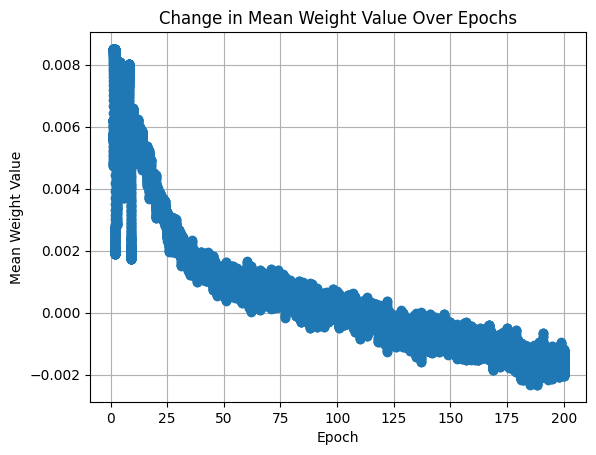

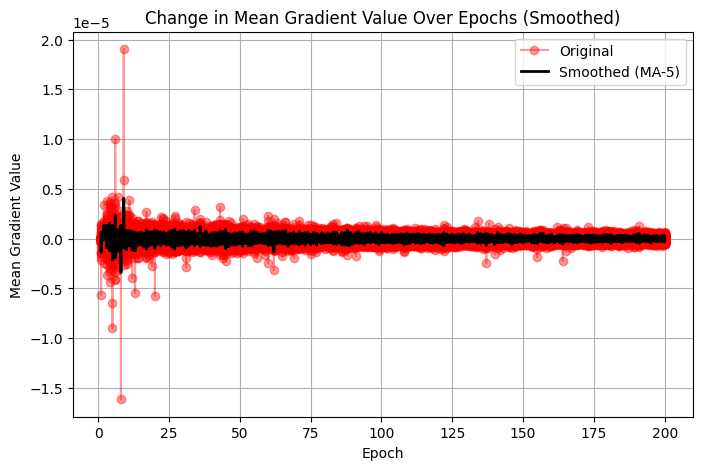

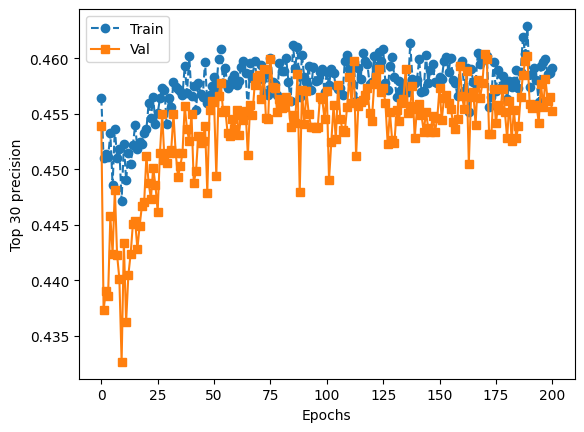

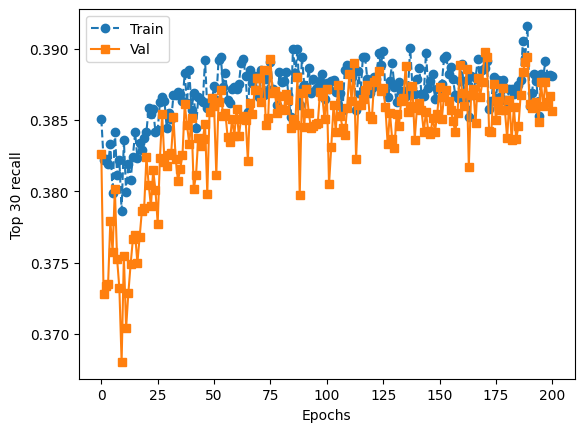

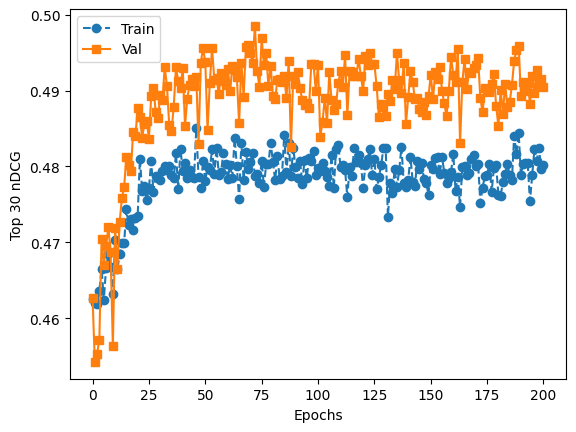

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ذخیره داده‌ها در یک فایل CSV برای بررسی و مقایسه تغییرات
df = pd.DataFrame(training_logs)
# رسم نمودار تغییر میانگین مقدار weight
plt.plot(df["epoch"], df["weight"], marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Mean Weight Value")
plt.title("Change in Mean Weight Value Over Epochs")
plt.grid()
plt.show()

# تنظیم پنجره میانگین متحرک
window_size = 5

# محاسبه مقدار صاف‌شده
df["smoothed_gradient"] = df["gradient"].rolling(window=window_size, min_periods=1).mean()

# رسم نمودار اصلی و صاف‌شده
plt.figure(figsize=(8, 5))
plt.plot(df["epoch"], df["gradient"], marker="o", linestyle="-", color="r", alpha=0.4, label="Original")
plt.plot(df["epoch"], df["smoothed_gradient"], color="black", linewidth=2, label=f"Smoothed (MA-{window_size})")
plt.xlabel("Epoch")
plt.ylabel("Mean Gradient Value")
plt.title("Change in Mean Gradient Value Over Epochs (Smoothed)")
plt.grid()
plt.legend()
plt.show()


K = config_dict["K"]
df_t = pd.DataFrame(train_topks)
df_v = pd.DataFrame(val_topks)


plt.plot(df_t["epoch"], df_t["train_topk_precision"], label="Train", linestyle="--", marker='o')
plt.plot(df_v["epoch"], df_v["val_topk_precision"], label="Val", linestyle="-", marker='s')
plt.ylabel(f"Top {K} precision")
plt.xlabel("Epochs")
plt.legend()
plt.show()


plt.plot(df_t["epoch"], df_t["train_topk_recall"], label="Train", linestyle="--", marker='o')
plt.plot(df_v["epoch"], df_v["val_topk_recall"], label="Val", linestyle="-", marker='s')
plt.ylabel(f"Top {K} recall")
plt.xlabel("Epochs")
plt.legend()
plt.show()


plt.plot(df_t["epoch"], df_t["train_topk_nDCG"], label="Train", linestyle="--", marker='o')
plt.plot(df_v["epoch"], df_v["val_topk_nDCG"], label="Val", linestyle="-", marker='s')
plt.ylabel(f"Top {K} nDCG")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [35]:
df = pipeline.get_layerwise_output_means()
print(df)

                   Block  MeanValue
0             LightGCN_0   0.000744
1  AttentionDotProduct_1  -0.002632


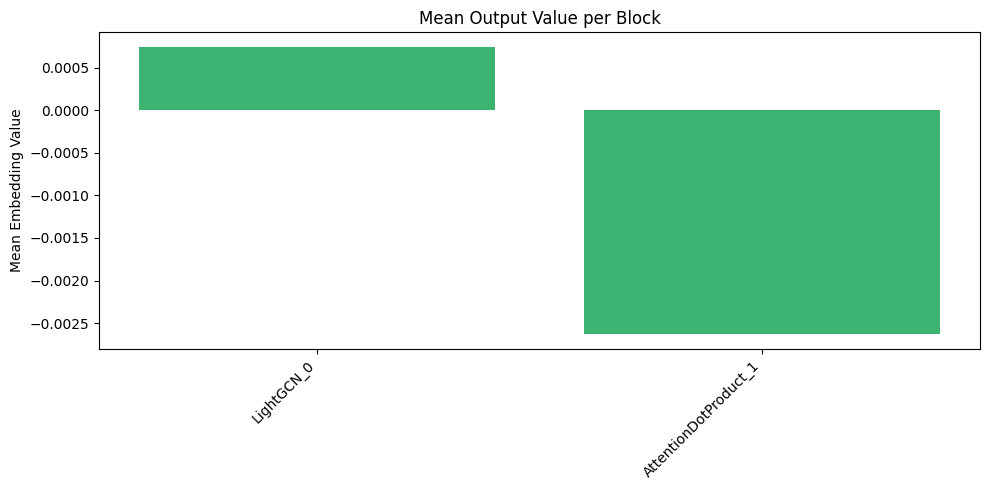

In [36]:
df = pipeline.get_layerwise_output_means()

plt.figure(figsize=(10, 5))
plt.bar(df["Block"], df["MeanValue"], color="mediumseagreen")
plt.title("Mean Output Value per Block")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Mean Embedding Value")
plt.tight_layout()
plt.show()

## Test

After training, let's test our model on the test set.

In [37]:
# ========== Final Evaluation on Test Set ==========
pipeline.eval()
users_test = samples_test[:, 0:1]
pos_test = samples_test[:, 1:2]
neg_test = samples_test[:, 2:3]

loss_test, reg_loss_test = bpr_loss(pipeline, users_test, pos_test, neg_test, data)
reg_loss_test = reg_loss_test * config_dict["weight_decay"]

user_indices = samples_test[:, 0].repeat(2).long()
item_indices = torch.cat((samples_test[:, 1], samples_test[:, 2])).long()
pred_test = getUsersRating(pipeline, users_test[:, 0], data)[user_indices, item_indices]
test_topk_precision, test_topk_recall,  test_topk_nDCG= personalized_topk(pred_test, config_dict["K"], user_indices, item_indices, data["edge_index"])

print("\n📌 Final Evaluation on Test Set:")
print("Average bpr_loss on the test set is {}, and regularization loss is {}.".format(round(float((loss_test + reg_loss_test) / len(samples_test)), 6),
                                                                                      round(float(reg_loss_test / len(samples_test)), 6)))
print("Test Top K precision = {}, recall = {} , nDCG = {}.".format(test_topk_precision, test_topk_recall,test_topk_nDCG))

# Save model
#torch.save(pipeline, config_dict["model_name"])



📌 Final Evaluation on Test Set:
Average bpr_loss on the test set is 1.7e-05, and regularization loss is 0.0.
Test Top K precision = 0.4511333405971527, recall = 0.3819907009601593 , nDCG = 0.48291972279548645.


# 